# CS Project 175 Phase 1

In [1]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install langdetect

     |████████████████████████████████| 981 kB 10.0 MB/s eta 0:00:01
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=f7d6d4e183cd333311c24f673da07d7f18cc76d292f5a244e68d1c398c3e8b8b
  Stored in directory: /Users/gouthamkarthi/Library/Caches/pip/wheels/d1/c1/d9/7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect


In [5]:
import pandas as pd
import numpy as np

from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model 
from sklearn import metrics 
from sklearn import preprocessing

import seaborn

# Analyzing the Data

In [6]:
data = pd.read_csv('./data/data.csv')
del data['Unnamed: 0']
data.head()

,title,genre,lyrics
0,the number of the beast,metal,woe to you o'er earth and sea\nfor the devil s...
1,fear of the dark,metal,i am a man who walks alone\nand when i'm walki...
2,the trooper,metal,you'll take my life but i'll take yours too\ny...
3,hallowed be thy name,metal,i'm waiting in my cold cell when the bell begi...
4,run to the hills,metal,white man came across the sea\nhe brought us p...


In [7]:
# plot labels
print('Num of rows', len(data))
seaborn.countplot(data, x='genre')
print('biggest class: ', (data['genre'] == max(data['genre'])).sum())
print('smallest class: ', (data['genre'] == min(data['genre'])).sum())


Num of rows 295242


/Users/gouthamkarthi/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## Building the Pipeline

In [22]:
RANDOM_STATE = 42

def gather_data():
    data = pd.read_csv('./data/data.csv')
    return data['lyrics'], data['genre']

def vectorize_labels(labels, classes=None):
    '''
    Vectorizes the labels.
    Returns as (indexes, labels)
    '''
    if classes is None:
        return pd.factorize(labels)
    return pd.Categorical(labels, categories=classes).codes, classes

def features_bow(data):
    vectorizer = CountVectorizer(stop_words='english', min_df=0.01, ngram_range=(1, 2))
    text = data.to_list()
    X = vectorizer.fit_transform(text)
    return X, vectorizer

def train_model_logistic(X, Y):
    classifier = linear_model.LogisticRegression(penalty='l2', multi_class='multinomial', random_state=RANDOM_STATE, fit_intercept=True, max_iter=100000)
    classifier.fit(X, Y)
    return classifier

def evaluate_logistic_model(model, X_train, Y_train, X_test, Y_test):
    train_accuracy = model.score(X_train, Y_train)
    print('\nTraining:')
    print(' accuracy:',format( 100*train_accuracy , '.2f') ) 

    # Compute and print accuracy on the test data
    print('\nTesting: ')
    test_accuracy = model.score(X_test, Y_test)
    print(' accuracy:', format( 100*test_accuracy , '.2f') )

    # Compute and print AUC on the test data
    class_probabilities = model.predict_proba(X_test)
    test_auc_score = metrics.roc_auc_score(Y_test, class_probabilities, multi_class='ovo')
    print(' AUC value:', format( 100*test_auc_score , '.2f') )

## Executing the Pipeline

In [23]:
# Phase 1 pipeline
inputs, labels = gather_data()

In [24]:
# convert to features
Y, classes = vectorize_labels(labels)
X, vectorizer = features_bow(inputs)

In [25]:
# split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=RANDOM_STATE)

In [26]:
# train model
model = train_model_logistic(X_train, Y_train)

## Evaluating the Model

In [13]:
evaluate_logistic_model(model, X_train, Y_train, X_test, Y_test)


Training:
 accuracy: 57.33

Testing: 
 accuracy: 56.30
 AUC value: 81.26


In [ ]:
def most_significant_terms(weights, vectorizer, K):
    pos_indices = np.argpartition(weights, -K)[-K:] # gather the K most positive indices
    pos_indices = pos_indices[np.argsort(-weights[pos_indices])] # sort the indices

    neg_indices = np.argpartition(weights, K)[:K] # gather the K most negative indices
    neg_indices = neg_indices[np.argsort(weights[neg_indices])] # sort the indices

    topK_pos_weights = weights[pos_indices]
    topK_neg_weights = weights[neg_indices]

    # gather the associated terms
    terms = vectorizer.get_feature_names_out()
    topK_pos_terms = terms[pos_indices]
    topK_neg_terms = terms[neg_indices]
        
    # print the positive weights and terms
    print('Top positive weights:')
    for i in range(len(topK_pos_weights)):
        print(format(topK_pos_weights[i], '.3f'), topK_pos_terms[i])
    
    # print the negative weights and terms
    print('Most negative weights:')
    for i in range(len(topK_neg_weights)):
        print(format(topK_neg_weights[i], '.3f'), topK_neg_terms[i])


In [ ]:
classes

In [ ]:
for i in range(len(classes)):
    print('Most Significant Terms for Class: "' + classes[i] + '"')
    most_significant_terms(model.coef_[i], vectorizer, 5)
    print()

In [ ]:
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)

np.random.seed(RANDOM_STATE)
NUM_EXAMPLES = 10
for _ in range(NUM_EXAMPLES):
    i = np.random.choice(np.where(predictions != Y_test)[0])
    print("Song Title:", data['title'][i])
    print('Predicted:', classes[predictions[i]], 'Actual:', classes[Y_test[i]])
    print('Probability:', probabilities[i][predictions[i]])
    print("Lyrics: ")
    print('"' + data['lyrics'][i][:100] + '..."')
    print()


In [ ]:
# Plot predictions to see distribution and if there is bias
test_predictions = [classes[i] for i in predictions]
test_predictions_df = pd.DataFrame(data=test_predictions, columns=["genre"])
seaborn.countplot(test_predictions_df, x="genre")

Validation Metrics

In [47]:
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt 

In [50]:
def cross_validation(model, _X, _y, folds=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      folds: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      score_method = ['accuracy']
      results = cross_validate(estimator=model,
                                   X=_X,
                                   y=_y,
                                   cv=folds,
                                   scoring=score_method,
                                   return_train_score=True)
      return results
    
    
# Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, validation_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_data: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         validation_data: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, validation_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

In [51]:
validation_metrics = cross_validation(model, X, Y)

In [52]:
print(validation_metrics)

{'fit_time': array([184.95527792, 209.32153797, 244.57867312, 232.00909996,
       198.26332712]), 'score_time': array([0.03310418, 0.09975123, 0.06398392, 0.076545  , 0.3845129 ]), 'test_accuracy': array([0.53731647, 0.62216126, 0.55265208, 0.51613941, 0.51637651]), 'train_accuracy': array([0.58032202, 0.55217555, 0.57204671, 0.58484551, 0.58673379])}


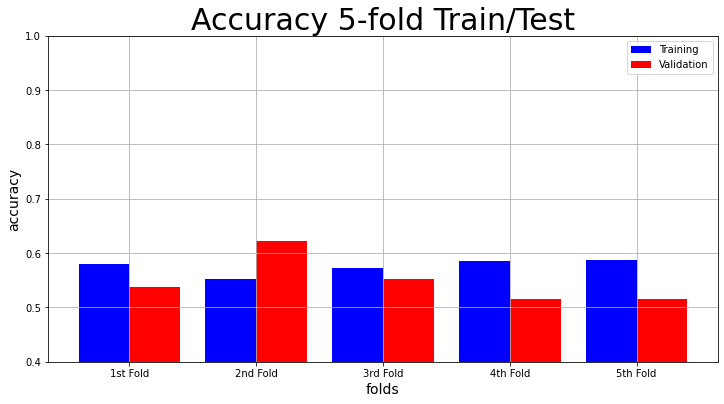

In [53]:
plot_result('folds', 'accuracy', 'Accuracy 5-fold Train/Test', validation_metrics['train_accuracy'], validation_metrics['test_accuracy'])